In [95]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import matplotlib.pyplot as plt
from datetime import timedelta, date

In [78]:
# volatility가 큰 기업들 가져오기
def get_stocks(start_date):
    print(start_date)
    
    start_date_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    
    year_ago = start_date_dt - timedelta(days=365)
    day_ago = start_date_dt - timedelta(days=1)
    
    df_price = marcap_data(year_ago.strftime("%Y-%m-%d"), day_ago.strftime("%Y-%m-%d")).reset_index()
    df_price = df_price[['Code', 'Close']]
    
    df_price = df_price.groupby('Code').agg([np.std, 'count'])
    df_price = df_price[df_price['Close']['count'] > 200]
    
    df_price = df_price.sort_values([('Close', 'std')], ascending=False)
    
    return df_price[:30].index.tolist()

In [84]:
df_account = pd.DataFrame(columns=['start_date', 'end_date'])

rows = []
for year in range(2002, 2020):
    rows.append({'start_date': str(year) + '-01-01', 'end_date': str(year) + '-12-31'})
df_account = df_account.append(rows)

In [85]:
df_account

,start_date,end_date
0,2002-01-01,2002-12-31
1,2003-01-01,2003-12-31
2,2004-01-01,2004-12-31
3,2005-01-01,2005-12-31
4,2006-01-01,2006-12-31
5,2007-01-01,2007-12-31
6,2008-01-01,2008-12-31
7,2009-01-01,2009-12-31
8,2010-01-01,2010-12-31
9,2011-01-01,2011-12-31


In [86]:
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.start_date), axis=1)

2002-01-01
2003-01-01
2004-01-01
2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01


In [87]:
df_account

,start_date,end_date,stocks
0,2002-01-01,2002-12-31,"[005300, 004990, 008975, 001000, 017050, 00530..."
1,2003-01-01,2003-12-31,"[005300, 004990, 052270, 003920, 036570, 01554..."
2,2004-01-01,2004-12-31,"[005930, 005300, 004370, 035420, 004990, 03525..."
3,2005-01-01,2005-12-31,"[004990, 005300, 003240, 005930, 003640, 06908..."
4,2006-01-01,2006-12-31,"[004990, 003240, 003920, 010780, 011000, 00593..."
5,2007-01-01,2007-12-31,"[003240, 002790, 035420, 005300, 011000, 00392..."
6,2008-01-01,2008-12-31,"[023790, 003240, 004990, 000670, 018415, 00530..."
7,2009-01-01,2009-12-31,"[009815, 024060, 012805, 003920, 005300, 00499..."
8,2010-01-01,2010-12-31,"[004990, 005930, 090430, 003240, 005935, 00549..."
9,2011-01-01,2011-12-31,"[003240, 012405, 017555, 030000, 090430, 00067..."


In [88]:
def get_daily_yield(row):
    threshold = row['Open'] + row['volatility'] * 0.5
    if row['High'] > threshold:
        return (row['Close'] / threshold) * 0.997
    else:
        return 1.0

In [89]:
def get_stock_yield(df_price, stock_code, start_date, end_date):
    df_price = df_price[df_price['Code'] == stock_code]
    
    if len(df_price) == 0:
        return None
    
    df_price = df_price[['Date', 'Open', 'Close', 'High', 'Low']]
    
    df_price['prev_high'] = df_price['High'].shift(1)
    df_price['prev_low'] = df_price['Low'].shift(1)
    
    df_price['volatility'] = df_price['prev_high'] - df_price['prev_low']
    df_price = df_price[1:]
    
    df_price['yield'] = df_price.apply(lambda x: get_daily_yield(x), axis=1)
    
    return df_price['yield'].cumprod().tail(1).item()

In [90]:
df_account

,start_date,end_date,stocks
0,2002-01-01,2002-12-31,"[005300, 004990, 008975, 001000, 017050, 00530..."
1,2003-01-01,2003-12-31,"[005300, 004990, 052270, 003920, 036570, 01554..."
2,2004-01-01,2004-12-31,"[005930, 005300, 004370, 035420, 004990, 03525..."
3,2005-01-01,2005-12-31,"[004990, 005300, 003240, 005930, 003640, 06908..."
4,2006-01-01,2006-12-31,"[004990, 003240, 003920, 010780, 011000, 00593..."
5,2007-01-01,2007-12-31,"[003240, 002790, 035420, 005300, 011000, 00392..."
6,2008-01-01,2008-12-31,"[023790, 003240, 004990, 000670, 018415, 00530..."
7,2009-01-01,2009-12-31,"[009815, 024060, 012805, 003920, 005300, 00499..."
8,2010-01-01,2010-12-31,"[004990, 005930, 090430, 003240, 005935, 00549..."
9,2011-01-01,2011-12-31,"[003240, 012405, 017555, 030000, 090430, 00067..."


In [91]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')

for i in range(len(df_account)):
    start_date = df_account.iloc[i].start_date
    end_date = df_account.iloc[i].end_date

    stocks = df_account.iloc[i].stocks
    yields = []

    df_price = marcap_data(start_date, end_date).reset_index()

    # 종목별 1년 수익률을 구한다.
    for stock in stocks:
        stock_yield = get_stock_yield(df_price, stock, start_date, end_date)
        if stock_yield:
            yields.append(stock_yield)
            print(stock, stock_yield)

    # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
    mean_yields = statistics.mean(yields)
    df_account.at[i, 'yield'] = mean_yields
    df_account.at[i, 'yields'] = yields

    print(start_date, '~', end_date, ":", mean_yields)

005300 1.1725295332607673
004990 2.253840065388423
008975 1.1740949081571252
001000 0.3953832354520689
017050 0.2927931724512911
005305 1.341512866064105
039530 0.5821726572853642
002240 0.9572985048620748
009620 8.987441436669371
036480 0.32175777084386764
027560 0.8141233294169226
003920 1.486179859940548
047610 0.869294468434075
024060 1.113549245818552
036420 0.4811425785719336
016040 0.5748503828602115
015545 7.372352971016129
017670 0.8189260250063464
005930 1.2179969972941695
003240 0.8260812882599633
002790 0.7254411030280767
023790 1.4816975974398685
020075 0.5285560017289451
023770 0.41176416975164626
046000 0.5450319741406704
043630 0.473769381976534
038420 0.8231115716445792
044960 0.6746652468468314
048830 0.8822606124201776
042110 0.4994690054242216
2002-01-01 ~ 2002-12-31 : 1.3366362653818287
005300 1.2161573050045458
004990 1.9730423564056665
052270 0.5156643946748125
003920 1.3492236698884972
036570 0.9813358238804164
015545 0.951964891760507
004965 6.630608266504027
0

In [93]:
df_account['total'] = df_account['yield'].cumprod()

df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))    

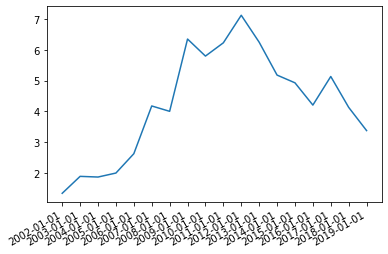

In [96]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

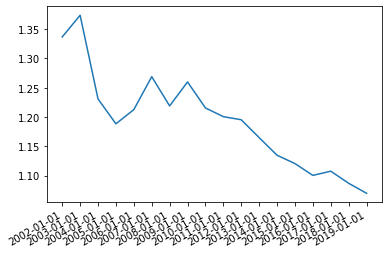

In [97]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()